# Document Reading Chat Bot - Notebook
Transform any document into a chat bot and ask it questions.

*For the purpose of this study, we will use the "Rules of Chess" article on Wikipedia*


## Table of Contents
- [Data Gathering And Transforming](#Data-Gat hering-And-Transforming)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Observation](Observation)
- [Feature Engineering](#Feature-Engineering)
- [Testing Data](#Testing-Data)
- [Model Performance Analysis](#Model-Performance-Analysis)
- [Conclusion](#Conclusion)



In [8]:
# __Environment__

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from gensim.models import KeyedVectors
from library import *

cd_data = 'data/'
cd_figures = 'figures/'
cd_docs = 'docs/'
cd_models = 'models/'

### Data Gathering And Transforming

In [3]:
# __Wrangle Data__
# load_wiki_article(cd_data=cd_data) # Comment out after article has been loaded once.
doc = read_wiki_article(cd_data=cd_data)
rules_of_chess = ProcessArticle(doc)

# __Transform__
token_df = pd.DataFrame({'token':rules_of_chess.tolest})
token_counts_df = pd.DataFrame(token_df['token'].value_counts())
token_1h_df = rules_of_chess.one_hot

# __Write To File__
token_df.to_csv(cd_data+'tokens.csv', index=False)
token_counts_df.to_csv(cd_data+'tokens_counts.csv')
token_1h_df.to_csv(cd_data+'tokens_1h.csv', index=False)


### Exploratory Data Analysis


,token
rule,96
player,94
chess,77
piece,71
game,68
king,61
square,56
time,55
pawn,40
wa,31


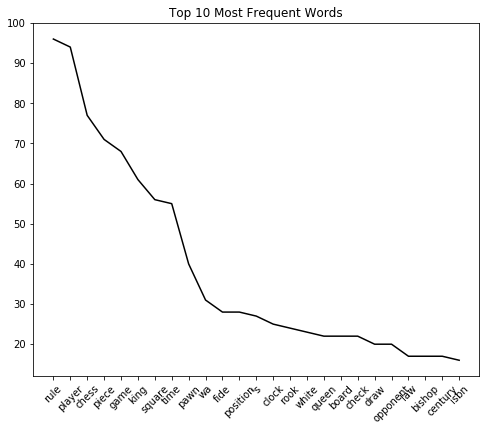

In [4]:
# __Plotting The Top 10 Most Frequent Words__
data = token_counts_df.groupby('token')
plot_title = 'top-10-most-frequent-words'
plt.figure(figsize=(8,6.5))
plt.title(plot_title.replace('-', ' ').title())
plt.plot(token_counts_df['token'][:25], color='black', label='STANDARD')
plt.savefig(cd_figures+plot_title+'.png', transparent=True)
plt.xticks(rotation=45)
token_counts_df.head(25)


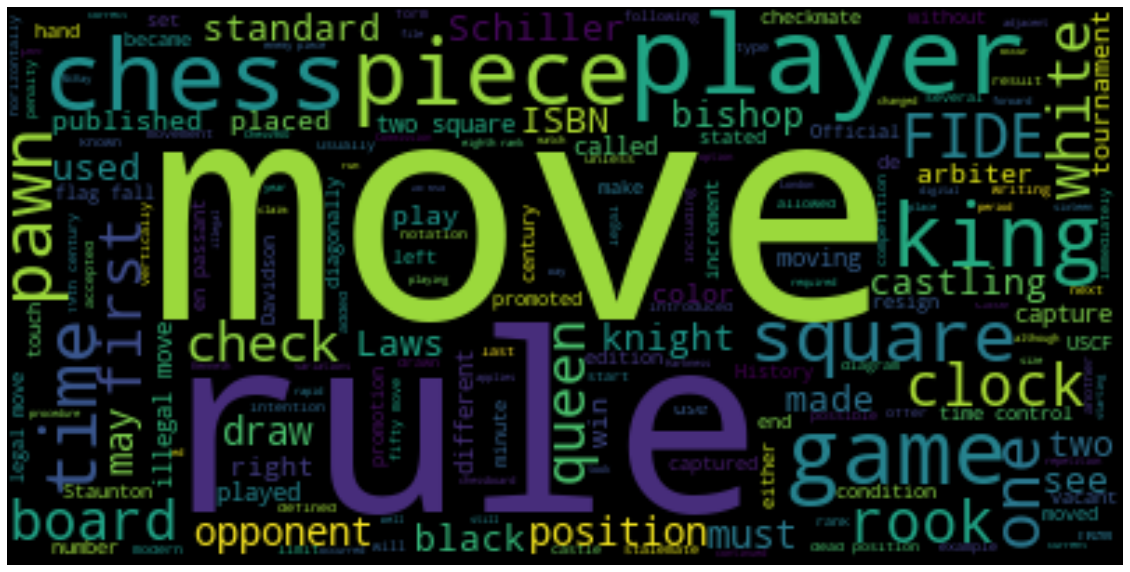

In [5]:
# __Generating Word Cloud__
wordcloud = WordCloud().generate(doc)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(cd_figures+'wordcloud.png', transparent=True)


In [6]:
# __Summary Statistics__
token_counts_df.describe()


,token
count,1070.000000
mean,2.927103
std,7.082721
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,96.000000


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

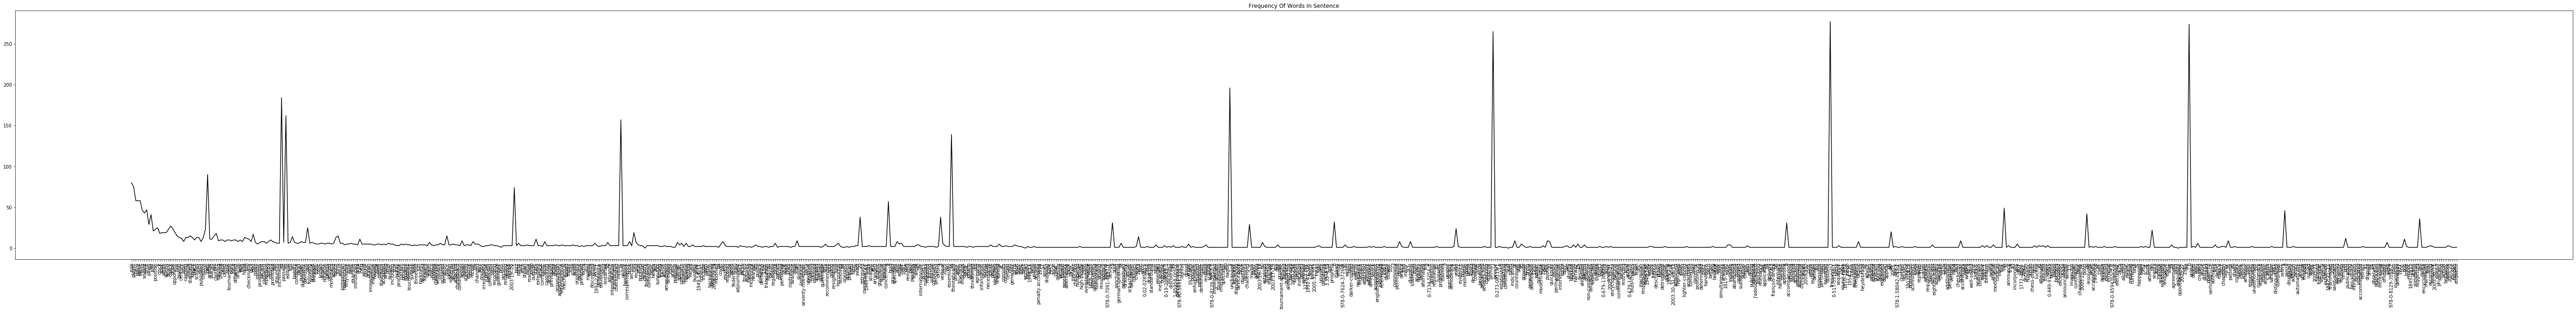

In [7]:
# __Token Frequency Within Sentences__
token_freq_df = count_token_frequency(rules_of_chess, token_counts_df)

plot_title = 'frequency-of-words-in-sentence'
plt.figure(figsize=(100,10))
plt.title(plot_title.replace('-', ' ').title())
plt.plot(token_freq_df.transpose()[0], color='black', label='STANDARD')
plt.savefig(cd_figures+plot_title+'.png', transparent=True)
plt.xticks(rotation=90)


### Observation
The most frequent words are not necessarily the words that are repeated.
After checking the "Frequency Of Words In Sentence" chart, it's clear that
words are repeated across the distribution within the same sentence.
Rule is the said the most, but not the most repeated. Which makes sense due to
the nature of the document.


### Feature Engineering
 Now that we have an idea of what the article looks like mathematically, we
can create a model based on the input. The model I have chosen is a
Frankenstein neural network using Word2Vec and ngrams to classify whether a
statement is true or false.


In [8]:
# __Model Creation & Testing__
# Import test data
test_df = pd.read_csv(cd_data+'test_data.csv')
test_df['predict'] = pd.NA
test_df['score'] = pd.NA

# Test parameters. Limits the number of test runs.
test_limit = 10 # for full use of the dataset use len(test_df)
number_of_tests = 10 # Number of times random parameters are generated

test_df = test_df.sample(frac=1).head(test_limit)

# Name associated reports and data files from the model's evaluation.
test_name = 'param_test_fullx10'



### Testing Data
 Training and validation data have been gathered using the scripts
"gather_articles.py" and "generate_validation_data.py." The data sets.

data/train_data.txt -> A large document containing ~1000 appended wiki
articles

data/train_sample.txt -> A modified wiki article for fast testing.

data/validation.csv -> A dataset containing sentences from the rules of rules_of_chess
and another random wiki article for performance measurement and model tuning.


In [9]:
# generate random parameters for random search parameter tuning.
google_vectors = KeyedVectors.load_word2vec_format(cd_models+'GoogleNews-vectors-negative300.bin', binary=True)

metrics_columns = ['gate', 'weight_mod', 'window', 'epochs', 'vector_scope',
   'vector_weight', 'TN', 'FP', 'FN', 'TP', 'accuracy', 'precision',
   'recall', 'false_positive_rate']

metrics_dict = {}
for column in metrics_columns:
    metrics_dict[column] = []

#Generate clean test file.
pd.DataFrame(metrics_dict).to_csv(cd_data+test_name+'.csv',
                                    index=False)



for test in tqdm(range(number_of_tests)):


    parameters = {'gate': np.random.randint(3, 100),
     'weight_mod': np.random.randint(1, 5)*np.random.random(),
     'window': np.random.randint(1, 15),
     'epochs': np.random.randint(1, 25),
     'vector_scope': np.random.randint(1,25),
     'vector_weight': np.random.randint(1, 20)*np.random.random()}

    # Genereate test data and write it to csv format.

    test_model, test_df = evaluate_model(read_article=rules_of_chess,
            train_article=None, # setting as None will load google KeyedVectors
            train_article_name='train_sample.txt',
            test_df=test_df,
            load_vectors=google_vectors,
            parameters=parameters,
            test_name=test_name)

    metrics = ModelMetrics(test_df=test_df)
    metrics_dict['gate'].append(test_model.gate)
    metrics_dict['weight_mod'].append(test_model.weight_mod)
    metrics_dict['window'].append(test_model.window)
    metrics_dict['epochs'].append(test_model.epochs)
    metrics_dict['vector_scope'].append(test_model.vector_scope)
    metrics_dict['vector_weight'].append(test_model.vector_weight)
    metrics_dict['TN'].append(metrics.matrix['TN'])
    metrics_dict['FP'].append(metrics.matrix['FP'])
    metrics_dict['FN'].append(metrics.matrix['FN'])
    metrics_dict['TP'].append(metrics.matrix['TP'])
    metrics_dict['accuracy'].append(metrics.accuracy)
    metrics_dict['precision'].append(metrics.precision)
    metrics_dict['recall'].append(metrics.recall)
    metrics_dict['false_positive_rate'].append(metrics.false_positive_rate)

        # test_df.to_csv(cd_data+test_name+'.csv', index=False)


        # initializing DataFrame.

    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df.to_csv(cd_data+test_name+'.csv',
                                            index=False,
                                            mode='a',
                                            header=False)

# Saving model params

test_group = metrics_df.groupby('accuracy').max().reset_index()
best_params = test_group[['gate', 'weight_mod', 'window', 'epochs', 'vector_scope', 'vector_weight']]
best_params.to_csv(cd_models+'parameters.csv', index=False)
parameters = best_params.transpose().to_dict()[0]


100%|██████████| 10/10 [02:56<00:00, 17.61s/it]


In [10]:
# __Test Results__
print(parameters)
metrics_df.sort_values('accuracy', ascending=False)


{'gate': 86.0, 'weight_mod': 2.505552278875024, 'window': 13.0, 'epochs': 19.0, 'vector_scope': 24.0, 'vector_weight': 11.595821205048505}


,gate,weight_mod,window,epochs,vector_scope,vector_weight,TN,FP,FN,TP,accuracy,precision,recall,false_positive_rate
0,44,0.088927,8,8,15,6.411457,4,0,5,1,0.5,1.0,0.166667,0.0
1,51,0.561540,3,5,12,7.855443,4,0,5,1,0.5,1.0,0.166667,0.0
4,64,3.782218,13,2,16,0.151508,4,0,5,1,0.5,1.0,0.166667,0.0
8,38,0.908300,3,2,21,10.228112,4,0,5,1,0.5,1.0,0.166667,0.0
2,55,0.148967,5,5,20,2.983805,4,0,6,0,0.4,0.0,0.000000,0.0
3,67,0.222679,13,6,15,0.527238,4,0,6,0,0.4,0.0,0.000000,0.0
5,74,1.552339,11,19,4,0.568733,4,0,6,0,0.4,0.0,0.000000,0.0
6,58,2.229879,5,7,7,0.705140,4,0,6,0,0.4,0.0,0.000000,0.0
7,58,2.505552,6,14,24,5.359222,4,0,6,0,0.4,0.0,0.000000,0.0
9,86,1.376876,13,1,9,11.595821,4,0,6,0,0.4,0.0,0.000000,0.0


### Model Performance Analysis
Ignoring that this model is likely over-fit at this point. We need to decide
what parameters we are willing to use. To do this, let's first decide how many
false positives we can allow. A false positive would mean the chat bot would
tell the user a statement is true when in fact it is false. This is very bad
and could cause extreme user frustration towards the product once put into
production. However we must also balance false negatives for the inverse
reason.

In an attempt to avoid further over-fitting, and because we can expect the
Word2Vec model to carry more weight when fully trained in on the Google VM,
I will continue with the following parameters.
----------------------
**After further investigation that the model was over fit due to a lack of
specific classified data. I have since added specific inputs and classified
them by hand to the test data. The issue with this is that it means the model
will not be able to read in general data and will always require specific
training to become usable. Because of this, I have opted to use Google's
pre-trained Word2Vec model for the vectors in this algorithm. These vectors
will provide general understanding for the model with better results, but will
still require specfic data to learn and test on in the form of user_docs.  **


In [11]:

# Model training done in the "model_training.py" file.

# Test user docs
user_doc = 'The game ends when a checkmate is declared.'
# user_doc = 'Pawns can move into an apartment'
# user_doc = 'The queen can move in any direction'
user_article = ProcessArticle(user_doc)

with open(cd_data+'train_sample.txt', 'r+') as file:
    train_doc = file.read()
train_article = ProcessArticle(train_doc)


trained_model = ChatBotModel(user_article=user_article,
read_article=rules_of_chess,
train_article=train_article,
train_article_name='train_data.txt',
load_vectors=google_vectors,
cd_data=cd_data,
test_df=test_df,
gate=parameters['gate'],
weight_mod=parameters['weight_mod'],
window=parameters['window'],
epochs=parameters['epochs'],
vector_scope=int(parameters['vector_scope']),
vector_weight=parameters['vector_weight'])


In [12]:
# __Simulation__
print(user_doc, '->', trained_model.prediction)

# __Parameters After Testing on Google cloud__
# {'gate': 20.0,
#  'weight_mod': 1.74327329492608,
#  'window': 13.0,
#  'epochs': 9.0,
#  'vector_scope': 12.0,
#  'vector_weight': 14.1647849325647}



The game ends when a checkmate is declared. -> (False, 25.729953945226253)


 ### Conclusion
It's clear that a statistical model is not able to just read in an article.
Other training steps are required. The chat bot that will be generated using
these methods will have very little expertise on the subject until more data
is added manually. This will require many inputs that are previously
classified as true or false to be added to the bot's database. Since the
model is currently acting more like a search engine, we can make use of this
feature by making the searchable data vast and high quality. The trade off to
this would be high amounts of training, tedious labeling, and excellent
vectors. So for our initial purpose of implementing an all-in-one chat bot
for support centers, legal documents, and labels, this project has shown that
there is not an all-in-one solution. However, if the bot was trained and
maintained to continuously become better, we could have what we are looking
for. The bottom line is that this is not practical for the average users and
could only be sold as a B2B service.